In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import torch
import numpy as np
from PIL import Image, ImageMath
from pycocotools.coco import COCO
import os
import skimage.io as io
import matplotlib.pyplot as plt
import yaml
from glob import glob
from copy import deepcopy
import cv2
import torchvision.models as models
from utils import tri_mirror

In [6]:
class TextureDataset(Dataset):
    def __init__(self, config, transform):
        self.root_dir = config['data']['data_dir']
        self.image_size = config['data']['image_size']
        self.image_type = config['data']['image_type']
        
        self.transform = transform
        self.img_channels = 1
        
        self.file_list = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                self.file_list.append(os.path.join(root, file))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        X = dict()
        img_path = self.file_list[idx]
        print("Img path: ", img_path)
        rivet = Image.open(img_path).resize((self.image_size, self.image_size))
        center = self.image_size // 2
        cv = self.image_size // 4
        
        if self.image_type == "Corrupted":
            rivet = np.array(rivet).astype(np.float32)
            center_rivet = deepcopy(rivet[center - cv: center + cv, center - cv: center + cv])
            rivet[center - cv: center + cv, center - cv: center + cv] = 0.0

#             rivet_rgb = np.zeros((rivet.shape[0], rivet.shape[0], 3))
#             rivet_rgb[:,:, 0] = rivet
#             rivet_rgb[:,:, 1] = rivet
#             rivet_rgb[:,:, 2] = rivet
            rivet = Image.fromarray((rivet*255).astype(np.uint8))
            center_rivet = center_rivet.astype(np.uint8)
            center_rivet = Image.fromarray(center_rivet)
                
        elif self.image_type == "TriMir":
            rivet = tri_mirror(rivet, center, cv)
            
        rivet = self.transform(rivet)
        center_rivet = self.transform(center_rivet)
        
        center_rivet = center_rivet.unsqueeze(0)

        X['Rivet'] = rivet
        X['Center'] = center_rivet
        
        return X

In [3]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

transform = transforms.Compose([transforms.ToTensor()])

dataset = TextureDataset(config, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

Img path:  /home/yyelisieiev/luftr_data/TextureDataset/train/Kyberge_floor1/37.jpg
torch.Size([1, 3, 64, 64])


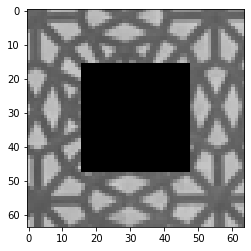

In [18]:
for index, inputs in enumerate(dataloader):
    print(inputs['Rivet'].shape)
    plt.imshow(inputs['Rivet'][0].permute(1, 2, 0))
    break
#         im.save(os.path.join(rivet_dir, f"{index}_{image_idx}_rivet.tif"))